In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import random
import seaborn as sns

# IMPORTANT

we decided to spplit each chapter to its own notebook as it becomes easier to read and follow along and eliminates silly bugs that happen from variable names duplication etc...
So we have 5 notebooks:

1) Data Description notebook which has the tables graph and further table processing.

2) Clusters notebook which includes both clustering algorithms of KMeans and GMM

3) Valid Vote Predictions notebook which includes the Random Forest alogrithm and process of predicting the amount of valid votes.

4) Party Votes Predictions notebook which includes the Adaboost alogrithm and process of predicting the amount of votes for given parties.

5) Supervisor Prediction notebook which includes the process of predicting in which cities to place a supervisor.


## Graph draw functions

In [3]:
def Votes_Dist_By_Loc(DataE,Prt_num):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = DataE.iloc[0:10,0].values
    labels = np.append(labels,str("Others"))
    sizes = DataE.iloc[0:10,Prt_num].values
    sizes = np.append(sizes,DataE.iloc[11:,Prt_num].values.sum(axis=0))
    explode = (0.1, 0, 0,0,0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:1.1f}% ({:d} )".format(pct, absolute)

    fig1, ax1 = plt.subplots(figsize=(12, 9), subplot_kw=dict(aspect="equal"), dpi= 80)
    ax1.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes),
            shadow=True, startangle=90)

    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(f"Votes Distribution of the party {DataE.columns[Prt_num]} by locality",fontweight=550,fontsize=20,color = 'red')

    plt.show()

In [4]:
def Votes_Party_Chart(dataE):
    # Prepare Constant Values
    TotalEligVot = dataE["eligble voters"].sum()
    TotalVot = dataE["voters"].sum()
    VotPerc = round(TotalVot/TotalEligVot , 3)
    ValidVot = dataE["valid"].sum()
    DropedVot = dataE["droped"].sum()
    # Prepare Data
    Xleg = dataE.columns[6:-2].tolist()
    Yleg = dataE.iloc[:,6:-2].values.sum(axis=0).tolist()

    n = dataE.columns[6:-2].unique().__len__()+1
    all_colors = list(plt.cm.colors.cnames.keys())
    random.seed(100)
    c = random.choices(all_colors, k=n)

    # Plot Bars
    plt.figure(figsize=(16,10), dpi= 80)
    plt.bar(Xleg, Yleg, color=c, width=.5)

    #plt.bar(Xleg, Yleg, color=c, width=.5)
    for i, val in enumerate(dataE.iloc[:,6:-2].values.sum(axis=0)):
        plt.text(i, val, f" {int(val)} ({round(val/TotalVot*100,2)}%)", horizontalalignment='center',rotation=85, verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

    # Decoration
    plt.gca().set_xticklabels(Xleg, rotation=90, horizontalalignment= 'center')
    plt.title(f"Number of Votes by Party   ,(TotalEligVot: {TotalEligVot},TotalVot: {TotalVot},VotPerc: {VotPerc},ValidVot: {ValidVot},DropedVot: {DropedVot})",fontweight=550,fontsize=12)
    plt.xlabel('Party Name')
    plt.ylabel('Num Of Votes')
    plt.ylim(0, 1700000)

In [5]:
def votes_perct_by_Religion(data, tb, index):
    
    index_df = pd.read_excel(xl, sheet_name='דת היישוב', header=None, usecols=[0, 1], 
                         names=['באור', 'religion']).dropna()
    index_df = index_df.drop(2, axis = 0)
    index_df["religion"] = index_df["religion"].astype(float)

    df = pd.merge(data, tb, on="sSymbol", how='inner')
    df = pd.merge(df, index_df, on="religion", how='left')
    df = df.groupby("באור", axis='rows').sum()

    Xleg = df.index
    Y1leg = df.voters
    Y2leg = df["eligble voters"]
    Y3leg = df.droped
    
   
    plt.figure(figsize=(16,10), dpi= 80)
    
    plt.bar(Xleg, Y2leg, color="green", width= 0.125, label = 'Total Voters'  )
    plt.bar(Xleg, Y1leg, color="red",width= 0.125, label = 'Voted', align='edge' )
    plt.bar(Xleg, Y3leg, color="blue", width= 0.125, label = 'Droped Votes', align='edge' )
    gca =  plt.gca()
    gca.set_ylim([0, max(df["eligble voters"]) + 100000])
    gca.set_xticklabels(Xleg, rotation=90, horizontalalignment= 'center')
    plt.title("Total Voters by Religion.")
    plt.xlabel('Religion')
    plt.ylabel('Eligble Voters Count')
    plt.legend(loc='upper right')
    plt.show()

In [6]:
def Droped_Votes_Locality(dataE):
    Xleg = dataE.sName
    Yleg = dataE.droped
    all_colors = list(plt.cm.colors.cnames.keys())
    random.seed(100)
    n = dataE.sName.unique().__len__()+1
    c = random.choices(all_colors, k=n)
    plt.figure(figsize=(16,10), dpi= 80)
    plt.bar(Xleg, Yleg, color=c, width=.5)
    gca =  plt.gca()
    gca.set_ylim([0, max(dataE.droped) + 100])
    gca.set_xticklabels(Xleg, rotation=90, horizontalalignment= 'center')
    plt.title("Top 10 Localities With the Most Dropped Votes.")
    plt.xlabel('Locality Name')
    plt.ylabel('Dropped Votes Count')
     
    plt.show()

## General Functions

In [8]:
def attach_district(table, tb, colname):
    
    data = pd.DataFrame(columns=tb.columns)
    names = []
    for s in table[colname]:
        data = data.append(tb.loc[tb[colname] == s], ignore_index=True)
        
    names = data["sName"].values
    data = data.drop("sName", axis=1).drop("sSymbol", axis=1)
    return data, names

In [9]:
def mutate_table(mapper, table):
    for k,v in mapper.items():
        if(len(v) > 1):
            col = table[v[0]]
            for i in range(1,len(v)):
                col += table[v[i]]
            for item in v:
                table = table.drop(item,axis=1)
            
            table[k] = col
        else:
            table.rename(columns={k:v[0]}, inplace=True)
    return table

In [10]:
def handleValue(size, value):
    if value is not None:
        return value
    else:
        return [0]*size

In [11]:
def remove_unicode_chars(columns):
    cols = []
    for col in columns:
        if isinstance(col, str):
            cols.append(col.replace("\u202c","").replace("\u202d",""))
        else:
            cols.append(col)
    
    return cols

In [12]:
def save_to_disk(name, model):
    # convert tree to jason
    with open(name, "w") as f:
        json_text = json.dumps(model)
        f.write(json_text)

# Loading Tables

Loading tables for the elections that group the votes by locality name and symbol these tables will be used throughout the whole assignment.
This includes tables description, graphs and tables processing.
Some column of party symbols were dropped completely because they didn't have enough votes to qualify and or thier influance was very miniscule (for example 0.0001%) that they weren't needed.

## Election 21

In [13]:
expcheb = pd.read_excel("settlments/expcheb.xlsx")

In [14]:
expcheb.head(2)

,sName,sSymbol,eligble voters,voters,droped,valid,‬אמת‭,‬ג‭,‬דעם‭,‬ום‭,...,‬צק‭,‬ץ‭,‬ץז‭,‬ץי‭,‬ק‭,‬קי‭,‬קן‭,‬קף‭,‬ר‭,‬שס
0,תירוש‭,‬10,333,237,2,235,4,3,0,0,...,0,0,0,0,0,0,0,0,0,73
1,מבשרת‭ ‬ציון‭,‬1015,18871,13883,37,13846,1000,81,3,23,...,3,0,0,2,15,5,3,0,0,457


In [15]:
expcheb.columns

Index(['sName', 'sSymbol', 'eligble voters', 'voters', 'droped', 'valid',
       '‬אמת‭', '‬ג‭', '‬דעם‭', '‬ום‭', '‬ז‭', '‬זי‭', '‬זך‭', '‬זנ‭', '‬זץ‭',
       '‬טב‭', '‬י‭', '‬יז‭', '‬ין‭', '‬יץ‭', '‬כ‭', '‬ךק‭', '‬ל‭', '‬מחל‭',
       '‬מרצ‭', '‬נ‭', '‬נז‭', '‬נך‭', '‬נץ‭', '‬נר‭', '‬ן‭', '‬ןך‭', '‬ןנ‭',
       '‬פה‭', '‬ףז‭', '‬ףי‭', '‬ףך‭', '‬ףנ‭', '‬ףץ‭', '‬צק‭', '‬ץ‭', '‬ץז‭',
       '‬ץי‭', '‬ק‭', '‬קי‭', '‬קן‭', '‬קף‭', '‬ר‭', '‬שס'],
      dtype='object')

In [16]:
expcheb.shape

(1212, 49)

## Election 23

In [17]:
expcheb3 = pd.read_excel("settlments/expc-3heb.xlsx")

In [18]:
expcheb3.head(2)

,sName,sSymbol,eligble voters,voters,droped,valid,‬אמת‭,‬ג‭,‬ודעם‭,‬ז‭,...,‬נק‭,‬פה‭,‬ףז‭,‬ץ‭,‬ק‭,‬קי‭,‬קך‭,‬קץ‭,‬שס‭,‬
0,‬אבו‭ ‬גווייעד‭ ‬שבט‭,‬967,2018,595,6,589,13,0,554,0,...,0,8,2,0,0,0,0,2,2‭,‬
1,‬אבו‭ ‬גוש‭,‬472,4821,2718,36,2682,75,4,2157,0,...,2,123,0,2,0,0,1,4,14‭,‬


In [19]:
expcheb3.columns

Index(['sName', 'sSymbol', 'eligble voters', 'voters', 'droped', 'valid',
       '‬אמת‭', '‬ג‭', '‬ודעם‭', '‬ז‭', '‬זך‭', '‬זץ‭', '‬טב‭', '‬י‭', '‬יז‭',
       '‬ינ‭', '‬יף‭', '‬יק‭', '‬יר‭', '‬כ‭', '‬כן‭', '‬ל‭', '‬מחל‭', '‬נ‭',
       '‬נז‭', '‬ני‭', '‬נץ‭', '‬נק‭', '‬פה‭', '‬ףז‭', '‬ץ‭', '‬ק‭', '‬קי‭',
       '‬קך‭', '‬קץ‭', '‬שס‭', '‬'],
      dtype='object')

In [20]:
expcheb3.shape

(1212, 37)

## Election 22

In [21]:
expcheb2 = pd.read_excel("settlments/expc-2heb.xlsx")

In [22]:
expcheb2.head(2)

,sName,sSymbol,eligble voters,voters,droped,valid,‬אמת‭,‬ג‭,‬ודעם‭,‬ז‭,...,‬פה‭,‬ףז‭,‬צ‭,‬צן‭,‬ץ‭,‬ק‭,‬קך‭,‬קץ‭,‬רק‭,‬שס
0,‬שחר‭,‬7,517,377,0,377,31,8,0,0,...,98,0,0,0,0,0,0,0,0,39
1,‬תירוש‭,‬10,332,245,0,245,1,4,0,1,...,6,0,0,0,0,0,0,0,0,104


In [23]:
expcheb2.columns

Index(['sName', 'sSymbol', 'eligble voters', 'voters', 'droped', 'valid',
       '‬אמת‭', '‬ג‭', '‬ודעם‭', '‬ז‭', '‬זכ‭', '‬זן‭', '‬זץ‭', '‬טב‭', '‬י‭',
       '‬יז‭', '‬ינ‭', '‬יף‭', '‬יק‭', '‬כ‭', '‬כי‭', '‬כף‭', '‬ל‭', '‬מחל‭',
       '‬מרצ‭', '‬נ‭', '‬נך‭', '‬נץ‭', '‬פה‭', '‬ףז‭', '‬צ‭', '‬צן‭', '‬ץ‭',
       '‬ק‭', '‬קך‭', '‬קץ‭', '‬רק‭', '‬שס'],
      dtype='object')

In [24]:
expcheb2.shape

(1212, 38)

### Loading demographic information table

In [25]:
tb = pd.read_excel("info/bycode2018heb.xlsx")
tb = tb.fillna(0)

tb.head()

,sName,sSymbol,district,subdistrict,Natural area,Municipal status,Metropolitan affiliation,religion,Total Population 2018,Jews and others,...,Arabs,Founding year,Current type of locality,Organizational affiliation,Coordinates,height,Planning Commission,Police space,year,Cluster Local Authorities
0,Shahar,7,6,61,612.0,50.0,0.0,1.0,875.0,875.0,...,0.0,1955,310,1.0,1.739861e+09,83.0,634.0,10001813.0,2018,0.0
1,Tirosh,10,1,11,112.0,26.0,0.0,1.0,501.0,501.0,...,0.0,1955,310,2.0,1.892863e+09,130.0,151.0,15000597.0,2018,0.0
2,Nir Hen,11,6,61,612.0,50.0,0.0,1.0,552.0,552.0,...,0.0,1955,310,1.0,1.729761e+09,91.0,634.0,10001813.0,2018,0.0
3,Hazeva,13,6,62,625.0,54.0,0.0,1.0,605.0,595.0,...,10.0,1965,310,1.0,2.266752e+09,-160.0,657.0,10001918.0,2018,610.0
4,No'am,15,6,61,612.0,34.0,0.0,1.0,349.0,349.0,...,0.0,1955,310,2.0,1.799961e+09,148.0,631.0,10001813.0,2018,0.0


In [26]:
tb.shape

(1482, 21)

## index 2018

this file includes additional information about the demographic information table, for example, matching religion numbers to actual religion type. this table can though of as an encoding table from columns in the other table

In [27]:
xl = pd.ExcelFile('info/index 2018heb.xlsx')
xl.sheet_names

['רשימת הגליונות בקובץ זה',
 'מחוז ונפה',
 'מעמד מוניציפלי',
 'אזור טבעי ',
 'דת היישוב',
 'וועדת תכנון',
 'שיוך מטרופוליני',
 'צורת יישוב',
 'השתייכות אירגונית',
 'תחנות משטרה',
 'אשכול רשויות מקומי']

In [28]:
# removing unicode chars from cells
symbols_col = [int(cell.replace("\u202c","").replace("\u202d","")) for cell in expcheb["sSymbol"]]
expcheb["sSymbol"] = symbols_col
symbols_col = [int(cell.replace("\u202c","").replace("\u202d","")) for cell in expcheb2["sSymbol"]]
expcheb2["sSymbol"] = symbols_col
symbols_col = [int(cell.replace("\u202c","").replace("\u202d","")) for cell in expcheb3["sSymbol"]]
expcheb3["sSymbol"] = symbols_col

# Graphs

### Election 21 Graphs

### Features correlations

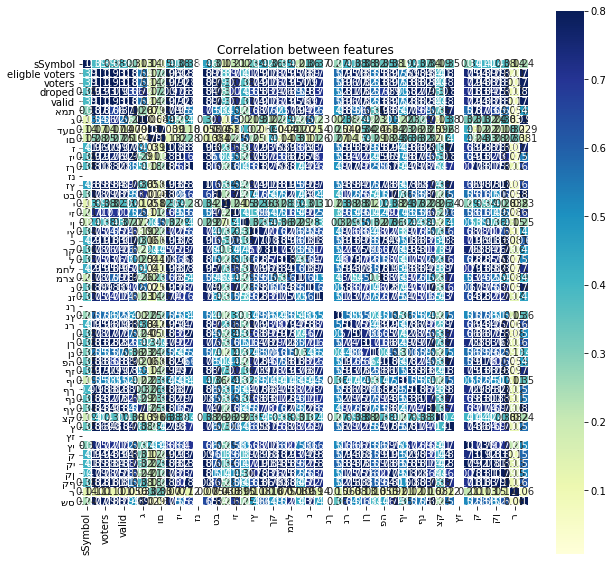

In [27]:
corr=expcheb.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

### Charts

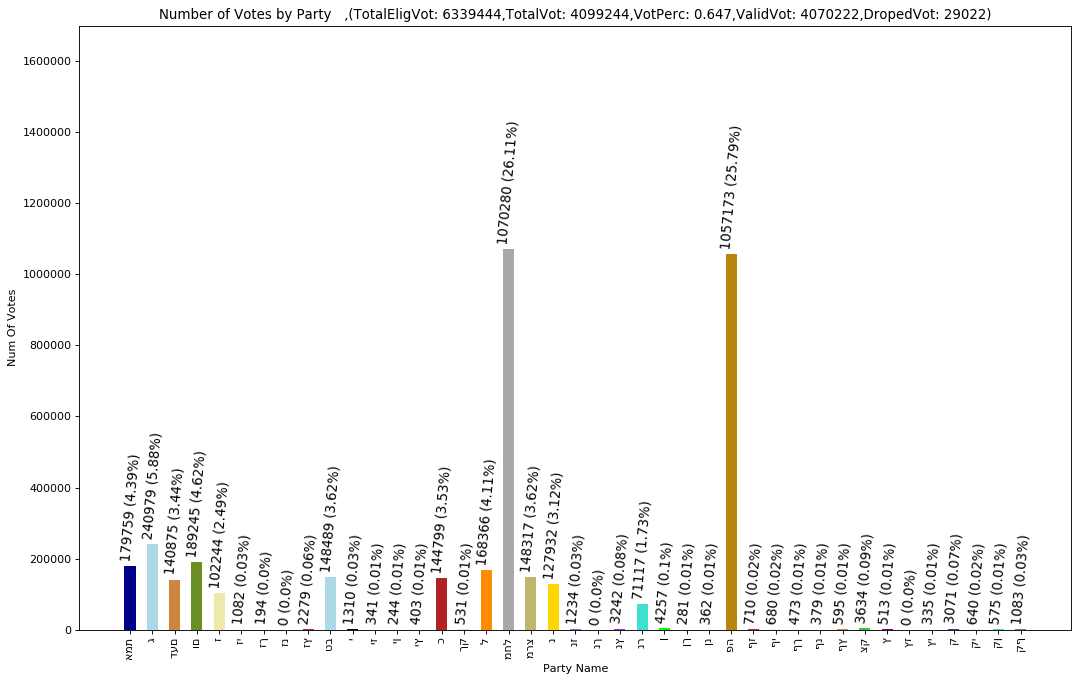

In [28]:
Votes_Party_Chart(expcheb)

In [29]:
sorted_expcheb = expcheb.sort_values(by = expcheb.columns[4],ascending=False, axis=0)
sorted_expcheb = sorted_expcheb.head(10)
sorted_expcheb

,sName,sSymbol,eligble voters,voters,droped,valid,‬אמת‭,‬ג‭,‬דעם‭,‬ום‭,...,‬צק‭,‬ץ‭,‬ץז‭,‬ץי‭,‬ק‭,‬קי‭,‬קן‭,‬קף‭,‬ר‭,‬שס
467,ירושלים‭,3000,410258,262103,2054,260049,7764,60632,407,1740,...,73,21,0,13,105,20,12,44,48,35773
891,בני‭ ‬ברק‭,6100,109000,84202,1398,82804,206,51178,6,10,...,11,10,0,0,14,3,1,7,3,21922
800,תל‭ ‬אביב‭ - ‬יפו‭,5000,426398,268795,1194,267601,22794,2397,1823,4375,...,121,34,0,10,206,29,24,27,36,8560
968,אשדוד‭,70,177630,117488,1107,116381,1755,13606,21,52,...,41,12,0,7,96,22,16,31,26,13262
683,חיפה‭,4000,247866,145606,1028,144578,8127,5210,1464,7319,...,188,36,0,15,173,35,15,41,56,2931
1164,באר‭ ‬שבע‭,9000,161391,98993,970,98023,2632,1275,143,288,...,47,16,0,3,82,22,14,21,32,5911
1066,פתח‭ ‬תקווה‭,7900,189414,131617,880,130737,4330,5676,21,62,...,58,11,0,9,86,21,11,35,24,7884
1012,נתניה‭,7400,181085,109241,818,108423,2891,3186,25,34,...,79,9,0,4,84,20,21,55,22,9461
925,חולון‭,6600,157915,101653,733,100920,4173,1030,19,60,...,73,11,0,10,104,16,15,13,28,7347
1110,ראשון‭ ‬לציון‭,8300,204949,138817,713,138104,5688,1145,28,67,...,82,14,0,5,124,14,15,58,14,3838


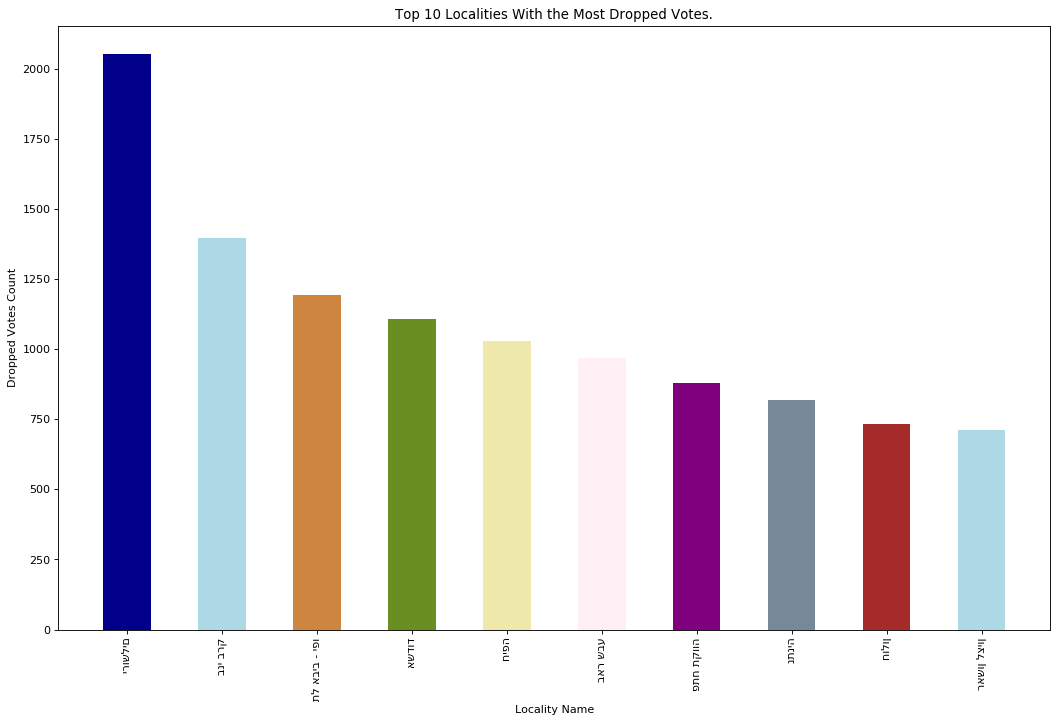

In [30]:
Droped_Votes_Locality(sorted_expcheb)

In [31]:
sorted_expcheb = expcheb.sort_values(by = expcheb.columns[23],ascending=False, axis=0)
sorted_expcheb.head(10)

,sName,sSymbol,eligble voters,voters,droped,valid,‬אמת‭,‬ג‭,‬דעם‭,‬ום‭,...,‬צק‭,‬ץ‭,‬ץז‭,‬ץי‭,‬ק‭,‬קי‭,‬קן‭,‬קף‭,‬ר‭,‬שס
467,ירושלים‭,3000,410258,262103,2054,260049,7764,60632,407,1740,...,73,21,0,13,105,20,12,44,48,35773
800,תל‭ ‬אביב‭ - ‬יפו‭,5000,426398,268795,1194,267601,22794,2397,1823,4375,...,121,34,0,10,206,29,24,27,36,8560
1110,ראשון‭ ‬לציון‭,8300,204949,138817,713,138104,5688,1145,28,67,...,82,14,0,5,124,14,15,58,14,3838
1164,באר‭ ‬שבע‭,9000,161391,98993,970,98023,2632,1275,143,288,...,47,16,0,3,82,22,14,21,32,5911
1066,פתח‭ ‬תקווה‭,7900,189414,131617,880,130737,4330,5676,21,62,...,58,11,0,9,86,21,11,35,24,7884
1012,נתניה‭,7400,181085,109241,818,108423,2891,3186,25,34,...,79,9,0,4,84,20,21,55,22,9461
968,אשדוד‭,70,177630,117488,1107,116381,1755,13606,21,52,...,41,12,0,7,96,22,16,31,26,13262
925,חולון‭,6600,157915,101653,733,100920,4173,1030,19,60,...,73,11,0,10,104,16,15,13,28,7347
683,חיפה‭,4000,247866,145606,1028,144578,8127,5210,1464,7319,...,188,36,0,15,173,35,15,41,56,2931
981,אשקלון‭,7100,112413,70010,616,69394,1285,1236,13,31,...,52,8,0,2,71,16,11,37,22,4708


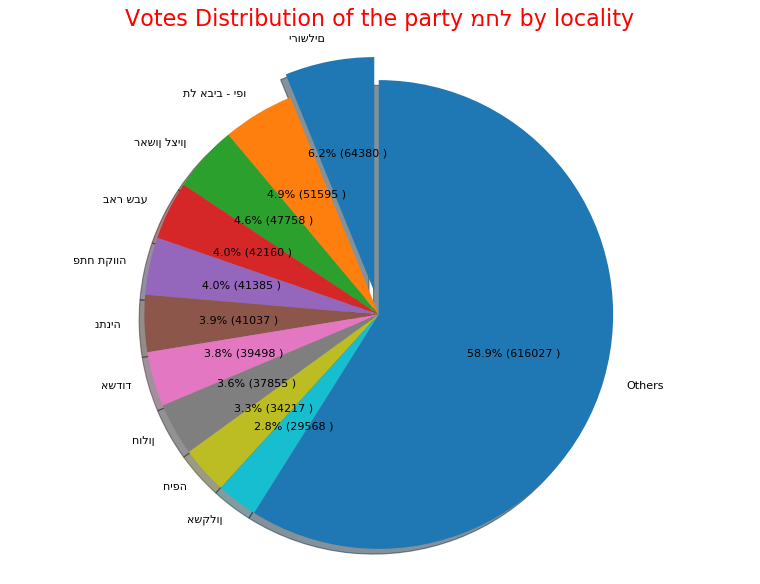

In [32]:
Votes_Dist_By_Loc(sorted_expcheb,23)

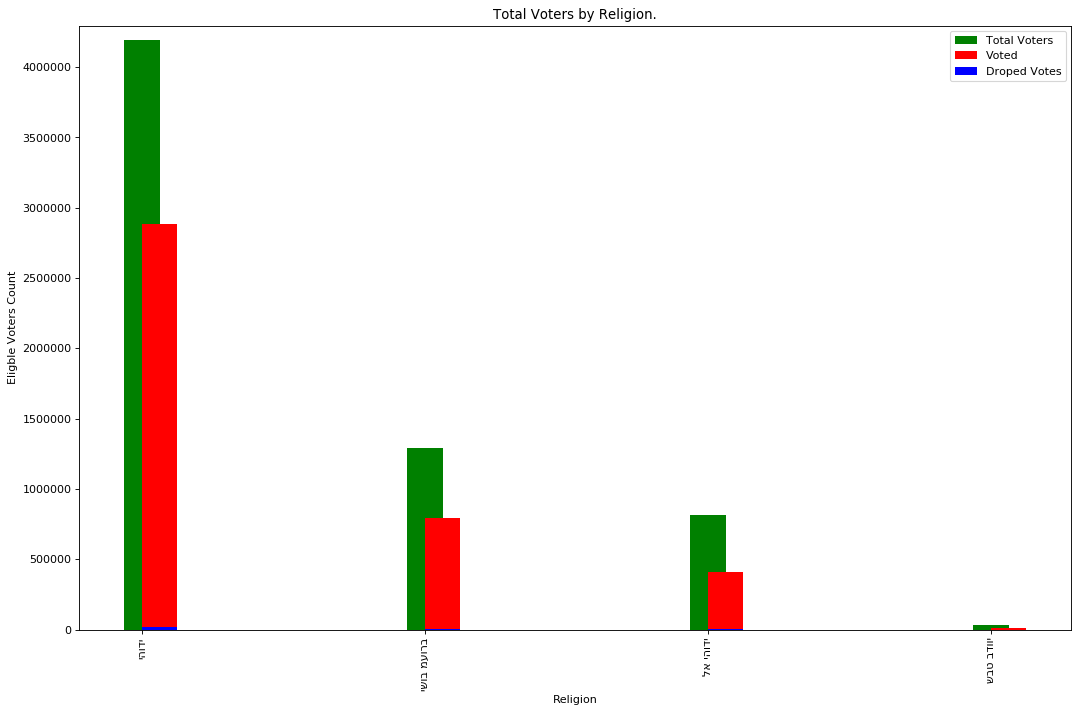

In [33]:
votes_perct_by_Religion(expcheb, tb, xl)

### Election 22 Graphs

### Features correlations

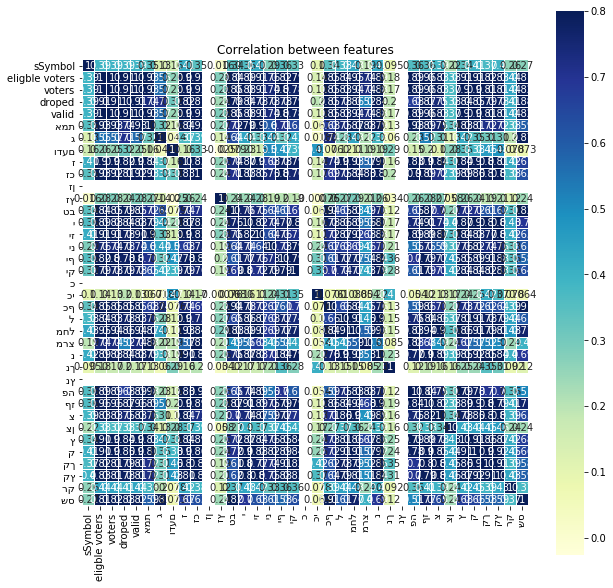

In [34]:
corr=expcheb2.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

### Charts

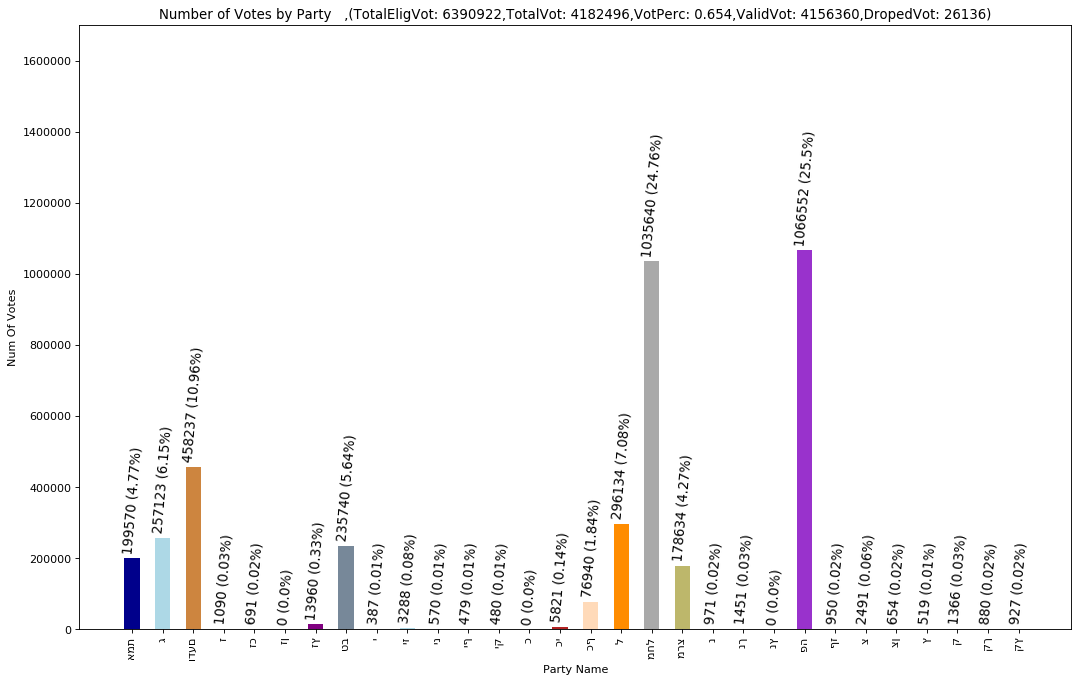

In [35]:
Votes_Party_Chart(expcheb2)

In [36]:
sorted_expcheb2 = expcheb2.sort_values(by = expcheb2.columns[4],ascending=False, axis=0)
sorted_expcheb2 = sorted_expcheb2.head(10)
sorted_expcheb2

,sName,sSymbol,eligble voters,voters,droped,valid,‬אמת‭,‬ג‭,‬ודעם‭,‬ז‭,...,‬פה‭,‬ףז‭,‬צ‭,‬צן‭,‬ץ‭,‬ק‭,‬קך‭,‬קץ‭,‬רק‭,‬שס
1010,‬ירושלים‭,3000,413140,261817,1840,259977,8846,64937,3582,44,...,30553,75,89,8,27,52,23,23,82,41531
1175,‬בני‭ ‬ברק‭,6100,110049,85032,1104,83928,355,51433,16,7,...,1129,7,10,3,3,3,6,4,8,23515
1173,‬תל‭ ‬אביב‭ - ‬יפו‭,5000,430203,267322,979,266343,19208,2934,8446,48,...,113843,59,122,12,32,60,31,29,73,10966
1135,‬חיפה‭,4000,248570,144888,846,144042,7885,5629,12697,52,...,47394,47,75,25,29,63,35,34,71,3952
1203,‬באר‭ ‬שבע‭,9000,161591,97425,816,96609,4169,1216,563,45,...,18163,37,79,7,9,43,21,15,43,8182
42,‬אשדוד‭,70,178302,116800,808,115992,3177,13627,35,33,...,18956,22,88,2,11,43,15,18,68,16300
1201,‬שפרעם‭,8800,28773,17039,712,16327,210,6,12071,4,...,1310,1,3,2,4,11,8,5,2,109
1196,‬ראשון‭ ‬לציון‭,8300,206016,137633,655,136978,7495,1225,104,46,...,50204,38,148,7,8,45,20,20,54,5791
1188,‬נתניה‭,7400,182945,108350,651,107699,3983,3543,53,31,...,26030,27,204,12,17,41,37,24,61,12844
1193,‬פתח‭ ‬תקווה‭,7900,190786,131353,643,130710,5850,6252,99,35,...,36532,35,118,6,13,44,13,18,69,9906


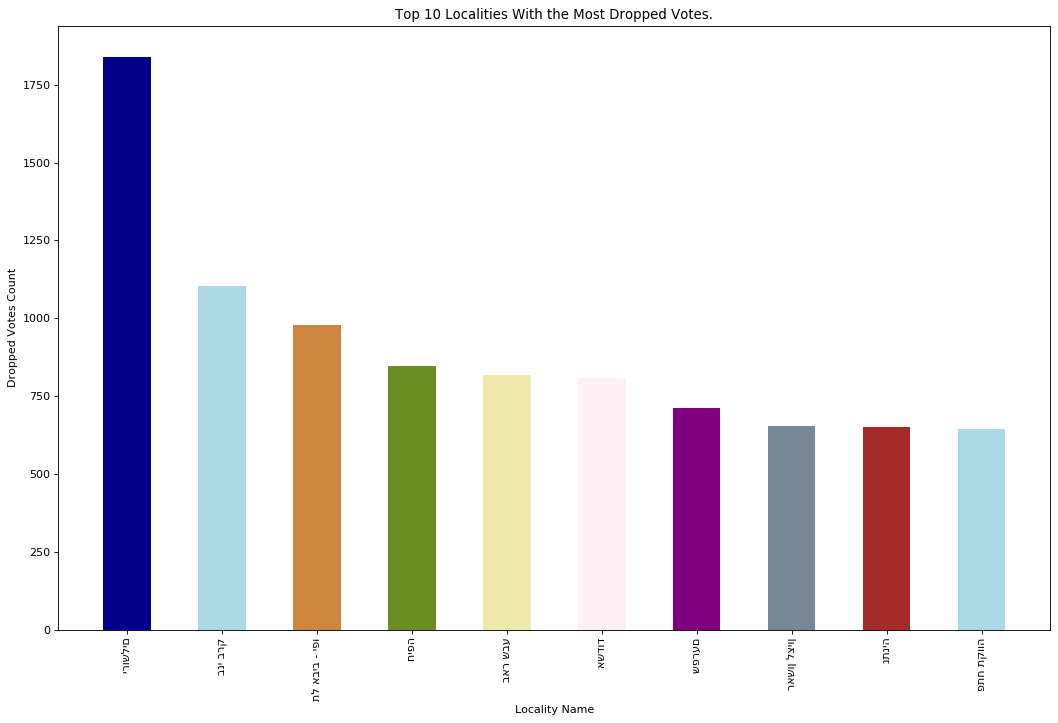

In [37]:
Droped_Votes_Locality(sorted_expcheb2)

In [38]:
sorted_expcheb2 = expcheb2.sort_values(by = expcheb2.columns[23],ascending=False, axis=0)
sorted_expcheb2.head(10)

,sName,sSymbol,eligble voters,voters,droped,valid,‬אמת‭,‬ג‭,‬ודעם‭,‬ז‭,...,‬פה‭,‬ףז‭,‬צ‭,‬צן‭,‬ץ‭,‬ק‭,‬קך‭,‬קץ‭,‬רק‭,‬שס
1010,‬ירושלים‭,3000,413140,261817,1840,259977,8846,64937,3582,44,...,30553,75,89,8,27,52,23,23,82,41531
1173,‬תל‭ ‬אביב‭ - ‬יפו‭,5000,430203,267322,979,266343,19208,2934,8446,48,...,113843,59,122,12,32,60,31,29,73,10966
1196,‬ראשון‭ ‬לציון‭,8300,206016,137633,655,136978,7495,1225,104,46,...,50204,38,148,7,8,45,20,20,54,5791
1203,‬באר‭ ‬שבע‭,9000,161591,97425,816,96609,4169,1216,563,45,...,18163,37,79,7,9,43,21,15,43,8182
1193,‬פתח‭ ‬תקווה‭,7900,190786,131353,643,130710,5850,6252,99,35,...,36532,35,118,6,13,44,13,18,69,9906
1188,‬נתניה‭,7400,182945,108350,651,107699,3983,3543,53,31,...,26030,27,204,12,17,41,37,24,61,12844
1180,‬חולון‭,6600,158451,101318,572,100746,5675,1056,95,38,...,30473,19,72,1,17,30,14,18,41,9867
42,‬אשדוד‭,70,178302,116800,808,115992,3177,13627,35,33,...,18956,22,88,2,11,43,15,18,68,16300
1135,‬חיפה‭,4000,248570,144888,846,144042,7885,5629,12697,52,...,47394,47,75,25,29,63,35,34,71,3952
1185,‬אשקלון‭,7100,113362,70918,487,70431,2283,1017,53,19,...,12210,24,82,6,16,37,14,13,64,7155


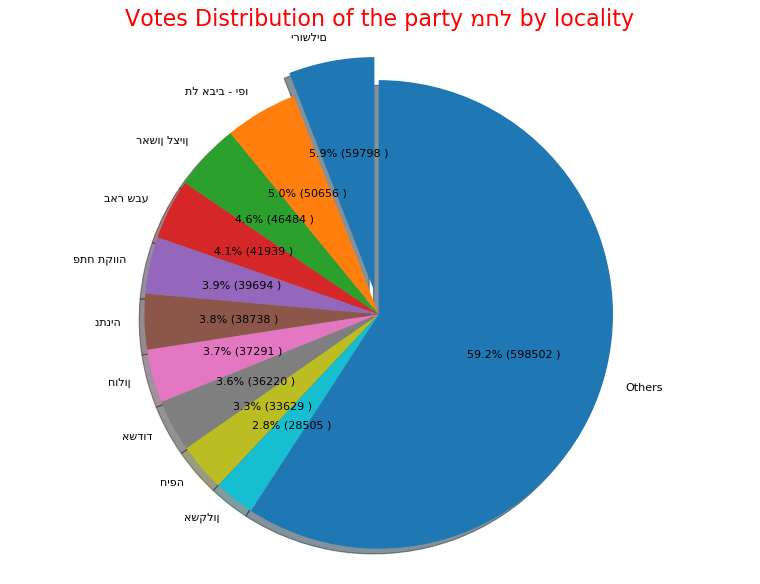

In [39]:
Votes_Dist_By_Loc(sorted_expcheb2,23)

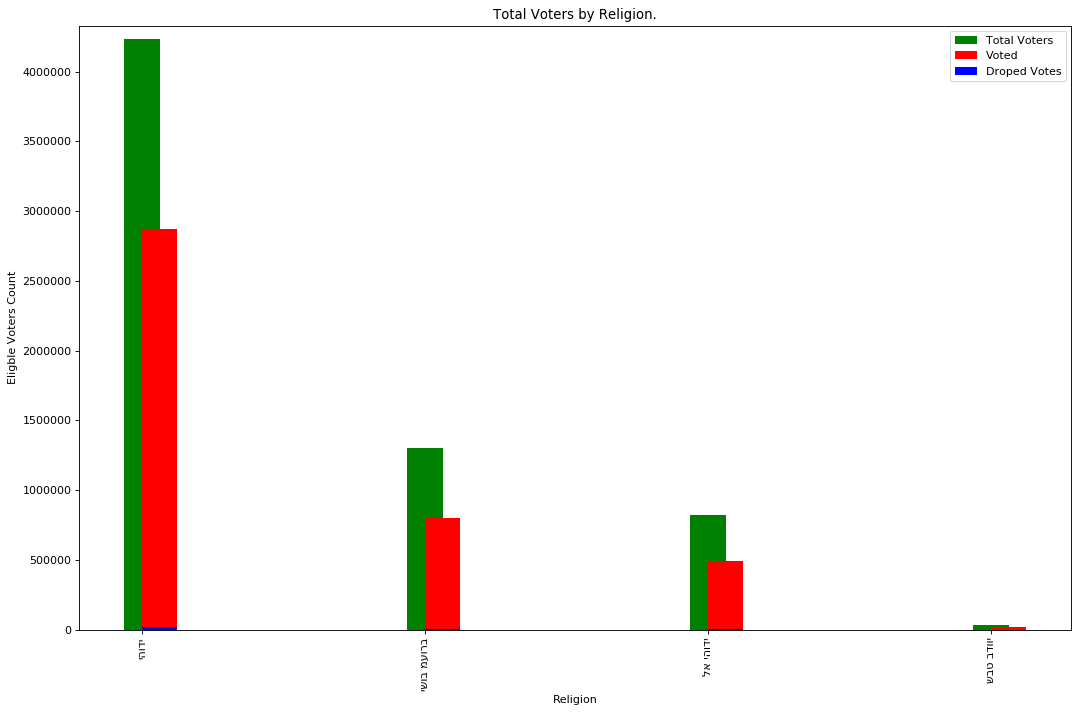

In [40]:
votes_perct_by_Religion(expcheb2, tb, xl)

In [ ]:
# clearing unsued variables
del sorted_expcheb2
del sorted_expcheb
del sorted_expcheb3

### Election 23 Graphs

### Features correlations

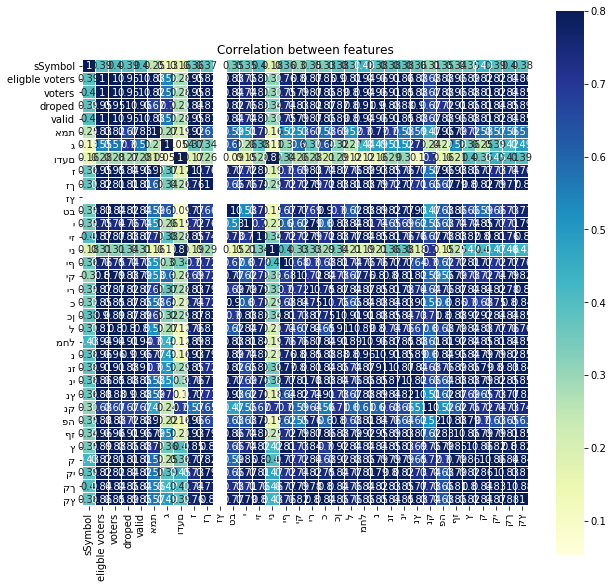

In [41]:
corr=expcheb3.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

### Charts

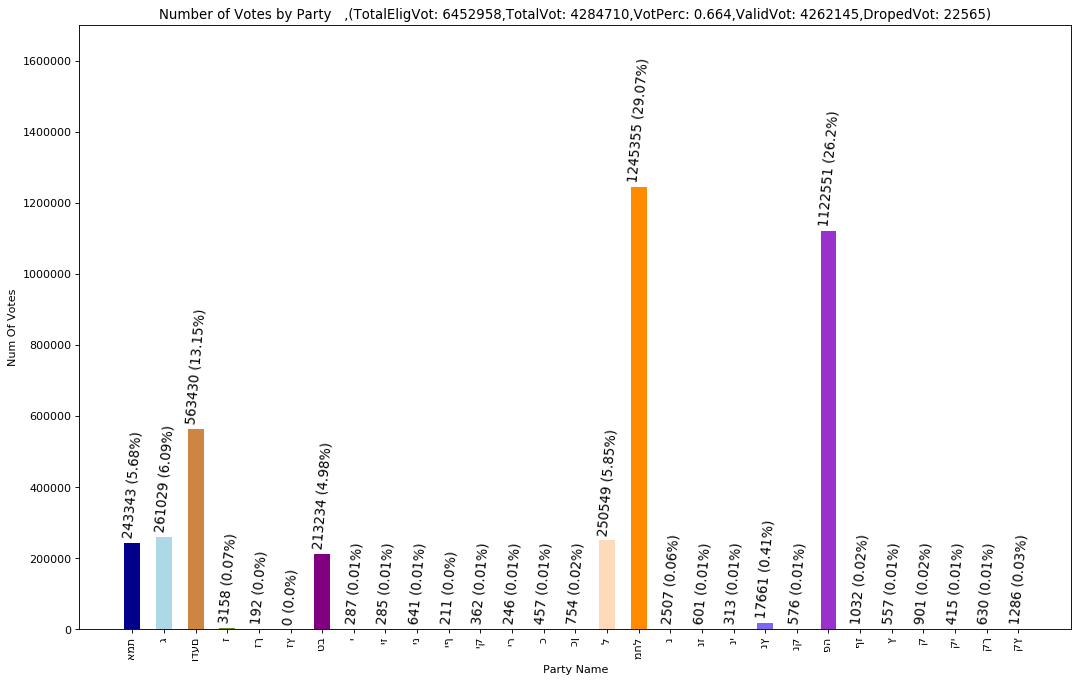

In [42]:
Votes_Party_Chart(expcheb3)

In [43]:
sorted_expcheb3 = expcheb3.sort_values(by = expcheb3.columns[4],ascending=False, axis=0)
sorted_expcheb3 = sorted_expcheb3.head(10)
sorted_expcheb3

,sName,sSymbol,eligble voters,voters,droped,valid,‬אמת‭,‬ג‭,‬ודעם‭,‬ז‭,...,‬נק‭,‬פה‭,‬ףז‭,‬ץ‭,‬ק‭,‬קי‭,‬קך‭,‬קץ‭,‬שס‭,‬
493,‬ירושלים‭,3000,415991,263214,1625,261589,12919,63782,5321,176,...,12,32800,77,19,21,18,29,79,44649‭,‬
1187,‬תל‭ ‬אביב‭ ‬יפו‭,5000,434208,268116,1001,267115,38808,2802,11413,319,...,16,128637,63,32,33,14,14,31,11179‭,‬
196,‬בני‭ ‬ברק‭,6100,111344,85775,929,84846,314,51922,22,15,...,1,1133,9,6,1,4,3,9,24389‭,‬
405,‬חיפה‭,4000,249627,145488,863,144625,10395,5604,14915,154,...,17,50081,46,35,51,17,19,58,4218‭,‬
129,‬באר‭ ‬שבע‭,9000,161968,100051,785,99266,3329,1360,770,87,...,9,17984,26,9,35,19,16,61,8860‭,‬
114,‬אשדוד‭,70,179046,118313,694,117619,2109,13731,64,58,...,11,18374,32,22,20,9,10,17,16994‭,‬
987,‬פתח‭ ‬תקווה‭,7900,191908,132135,646,131489,5045,6346,191,118,...,10,37442,34,20,21,9,13,28,10805‭,‬
859,‬נתניה‭,7400,184613,110399,636,109763,3265,3602,109,86,...,15,25906,22,18,26,7,25,32,13241‭,‬
1056,‬ראשון‭ ‬לציון‭,8300,207038,138490,596,137894,6268,1166,190,121,...,8,50944,30,16,30,7,16,28,6151‭,‬
392,‬חולון‭,6600,158891,101584,518,101066,4606,894,163,92,...,9,31303,36,13,23,11,13,31,10345‭,‬


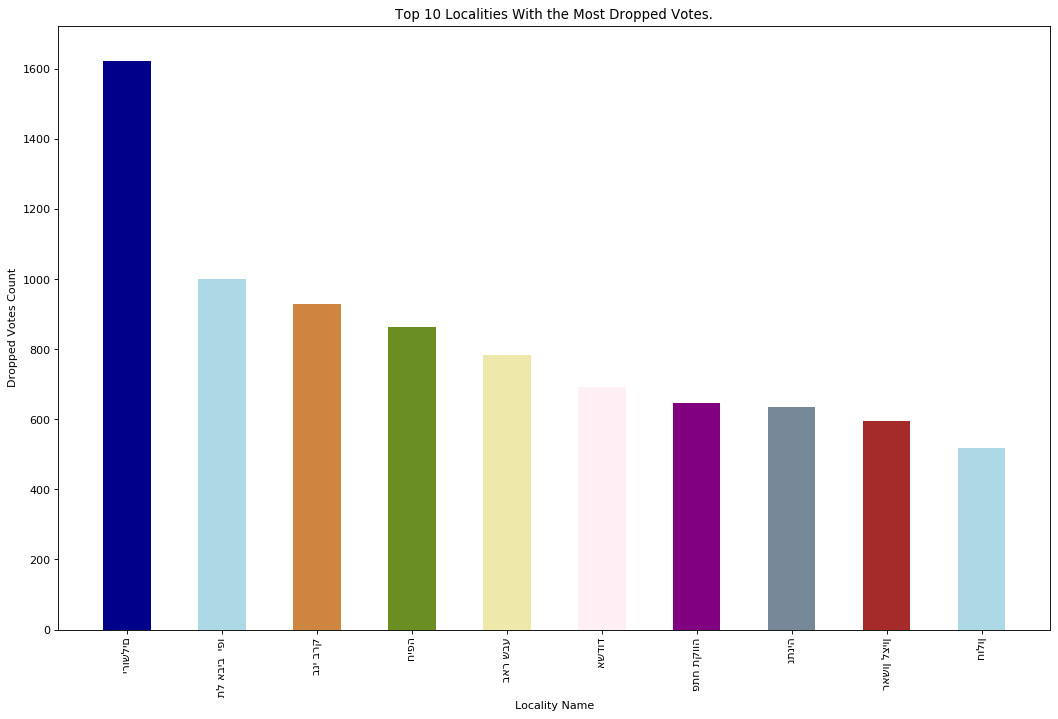

In [44]:
Droped_Votes_Locality(sorted_expcheb3)

In [45]:
sorted_expcheb3 = expcheb3.sort_values(by = expcheb3.columns[23],ascending=False, axis=0)
sorted_expcheb3.head(10)

,sName,sSymbol,eligble voters,voters,droped,valid,‬אמת‭,‬ג‭,‬ודעם‭,‬ז‭,...,‬נק‭,‬פה‭,‬ףז‭,‬ץ‭,‬ק‭,‬קי‭,‬קך‭,‬קץ‭,‬שס‭,‬
493,‬ירושלים‭,3000,415991,263214,1625,261589,12919,63782,5321,176,...,12,32800,77,19,21,18,29,79,44649‭,‬
1187,‬תל‭ ‬אביב‭ ‬יפו‭,5000,434208,268116,1001,267115,38808,2802,11413,319,...,16,128637,63,32,33,14,14,31,11179‭,‬
987,‬פתח‭ ‬תקווה‭,7900,191908,132135,646,131489,5045,6346,191,118,...,10,37442,34,20,21,9,13,28,10805‭,‬
405,‬חיפה‭,4000,249627,145488,863,144625,10395,5604,14915,154,...,17,50081,46,35,51,17,19,58,4218‭,‬
1056,‬ראשון‭ ‬לציון‭,8300,207038,138490,596,137894,6268,1166,190,121,...,8,50944,30,16,30,7,16,28,6151‭,‬
392,‬חולון‭,6600,158891,101584,518,101066,4606,894,163,92,...,9,31303,36,13,23,11,13,31,10345‭,‬
859,‬נתניה‭,7400,184613,110399,636,109763,3265,3602,109,86,...,15,25906,22,18,26,7,25,32,13241‭,‬
129,‬באר‭ ‬שבע‭,9000,161968,100051,785,99266,3329,1360,770,87,...,9,17984,26,9,35,19,16,61,8860‭,‬
1085,‬רמת‭ ‬גן‭,8600,132937,87752,331,87421,8641,1041,573,114,...,1,40735,29,9,7,2,12,16,3332‭,‬
114,‬אשדוד‭,70,179046,118313,694,117619,2109,13731,64,58,...,11,18374,32,22,20,9,10,17,16994‭,‬


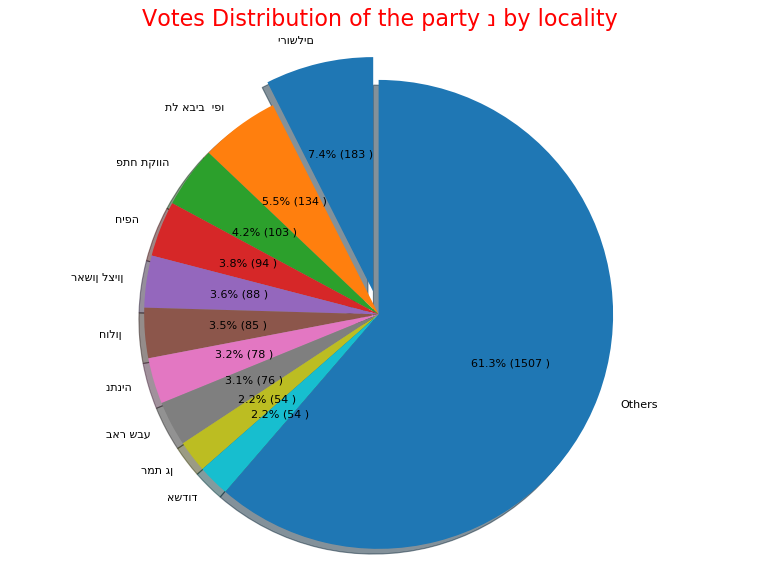

In [46]:
Votes_Dist_By_Loc(sorted_expcheb3,23)

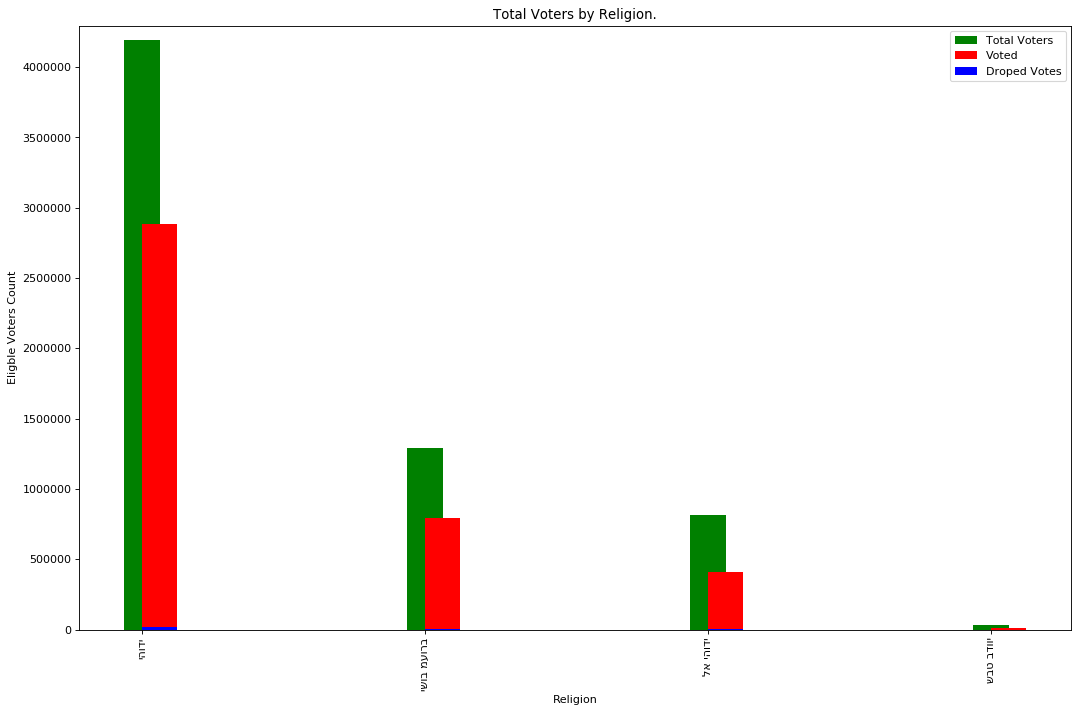

In [47]:
votes_perct_by_Religion(expcheb, tb, xl)

# Preparring tables and removing unicode characters

Prior to loading the tables in, we converted the csv files to excel format with urf-8 encoding which generated some unicode chars around each column name and some cells. So in this section we remove rhese chars

In [48]:
cols = [col.replace("\u202c","").replace("\u202d","") for col in expcheb.columns]
expcheb.columns = cols
cols = [col.replace("\u202c","").replace("\u202d","") for col in expcheb2.columns]
expcheb2.columns = cols
cols = [col.replace("\u202c","").replace("\u202d","") for col in expcheb3.columns]
expcheb3.columns = cols

# droping praties that has miniscule influance. 
expcheb = expcheb.drop("זך",axis=1)
expcheb = expcheb.drop("י",axis=1)
expcheb = expcheb.drop("נץ",axis=1)

## Encoding party names with numbers

In [49]:
# collecting all parties symbols
columnsSet = set(expcheb.columns[6:])
columnsSet.update(expcheb2.columns[6:])
columnsSet.update(expcheb3.columns[6:])

In [50]:
columnsSet.remove('')

In [51]:
columnsSet

{'אמת',
 'ג',
 'דעם',
 'ודעם',
 'ום',
 'ז',
 'זי',
 'זך',
 'זכ',
 'זן',
 'זנ',
 'זץ',
 'טב',
 'י',
 'יז',
 'ין',
 'ינ',
 'יף',
 'יץ',
 'יק',
 'יר',
 'ךק',
 'כ',
 'כי',
 'כן',
 'כף',
 'ל',
 'מחל',
 'מרצ',
 'ן',
 'ןך',
 'ןנ',
 'נ',
 'נז',
 'ני',
 'נך',
 'נץ',
 'נק',
 'נר',
 'ףז',
 'ףי',
 'ףך',
 'ףנ',
 'ףץ',
 'פה',
 'ץ',
 'ץז',
 'ץי',
 'צ',
 'צן',
 'צק',
 'ק',
 'קי',
 'קך',
 'קן',
 'קף',
 'קץ',
 'ר',
 'רק',
 'שס'}

In [52]:
lbl2vword = dict()
word2lbl = dict()
# encoding parties
for v, k in enumerate(columnsSet,1):
    if k != '':
        lbl2vword[v]= k
        word2lbl[k]= v

In [53]:
# renaming columns
expcheb.rename(columns=word2lbl, inplace=True)
expcheb2.rename(columns=word2lbl, inplace=True)
expcheb3.rename(columns=word2lbl, inplace=True)

In [54]:
expcheb.head(2)

,sName,sSymbol,eligble voters,voters,droped,valid,2,55,60,31,...,28,51,35,47,22,37,13,29,17,54
0,תירוש‭,10,333,237,2,235,4,3,0,0,...,0,0,0,0,0,0,0,0,0,73
1,מבשרת‭ ‬ציון‭,1015,18871,13883,37,13846,1000,81,3,23,...,3,0,0,2,15,5,3,0,0,457


In [55]:
expcheb2.head(2)

,sName,sSymbol,eligble voters,voters,droped,valid,2,55,40,8,...,53,23,16,20,51,22,42,39,33,54
0,‬שחר‭,7,517,377,0,377,31,8,0,0,...,98,0,0,0,0,0,0,0,0,39
1,‬תירוש‭,10,332,245,0,245,1,4,0,1,...,6,0,0,0,0,0,0,0,0,104


In [56]:
expcheb3.head(2)

,sName,sSymbol,eligble voters,voters,droped,valid,2,55,40,8,...,19,53,23,51,22,37,42,39,54,
0,‬אבו‭ ‬גווייעד‭ ‬שבט‭,967,2018,595,6,589,13,0,554,0,...,0,8,2,0,0,0,0,2,2‭,‬
1,‬אבו‭ ‬גוש‭,472,4821,2718,36,2682,75,4,2157,0,...,2,123,0,2,0,0,1,4,14‭,‬


## Merging party symbols

In this section we'll be merging party symbols based on the fact that some parties chose merge or change thier symbol. We adjust each symbol to mtach it's corresponding one in election 23 table.

In [57]:
# columns to be merged or renmaed in table 23
mapper3 = dict()
mapper3[word2lbl["ינ"]] = [word2lbl["ין"]]
mapper3[word2lbl["נץ"]] = [word2lbl["כף"]]

In [58]:
# columns to be merged or renmaed in table 22
mapper2 = dict()
mapper2[word2lbl["קץ"]] = [word2lbl["ני"]]
mapper2[word2lbl["י"]] = [word2lbl["יר"]]
mapper2[word2lbl["ץ"]] = [word2lbl["כן"]]
mapper2[word2lbl["נ"]] = [word2lbl["נק"]]
mapper2[word2lbl["אמת"]] = [word2lbl["אמת"], word2lbl["מרצ"]]

In [59]:
# columns to be merged or renmaed in table 21
mapper = dict()
mapper[word2lbl["ןך"]] = [word2lbl["יף"]]
mapper[word2lbl["יז"]] = [word2lbl["יק"]]
mapper[word2lbl["ןנ"]] = [word2lbl["יר"]]
mapper[word2lbl["ז"]] = [word2lbl["זן"]]
mapper[word2lbl["אמת"]] = [word2lbl["אמת"], word2lbl["מרצ"], word2lbl["נר"]]
mapper[word2lbl["ודעם"]] = [word2lbl["דעם"], word2lbl["ום"]]
mapper

{27: [30], 45: [11], 41: [58], 8: [24], 2: [2, 9, 32], 40: [60, 31]}

In [60]:
expcheb = mutate_table(mapper, expcheb)
expcheb.columns

Index([         'sName',        'sSymbol', 'eligble voters',         'voters',
               'droped',          'valid',               55,               24,
                     50,               36,                7,                6,
                     11,               15,               59,                3,
                      4,               43,               49,               52,
                     12,               46,               56,               30,
                     58,               53,               23,               25,
                     21,               26,               10,               28,
                     51,               35,               47,               22,
                     37,               13,               29,               17,
                     54,                2,               40],
      dtype='object')

In [61]:
expcheb2 = mutate_table(mapper2, expcheb2)
expcheb2.columns

Index([         'sName',        'sSymbol', 'eligble voters',         'voters',
               'droped',          'valid',               55,               40,
                      8,               34,               24,                7,
                      6,               58,               45,                5,
                     30,               11,                3,               14,
                     57,               43,               49,               19,
                     46,               38,               53,               23,
                     16,               20,               44,               22,
                     42,                1,               33,               54,
                      2],
      dtype='object')

In [62]:
expcheb3 = mutate_table(mapper3, expcheb3)
expcheb3.columns

Index([         'sName',        'sSymbol', 'eligble voters',         'voters',
               'droped',          'valid',                2,               55,
                     40,                8,               18,                7,
                      6,               48,               45,               15,
                     30,               11,               58,                3,
                     44,               43,               49,               52,
                     12,                1,               57,               19,
                     53,               23,               51,               22,
                     37,               42,               39,               54,
                     ''],
      dtype='object')

## Generate new tables

in this section we generate new tables for each table that hold every encoded party symbol.
The idea behind it is ensude every table has the same dimenssion wich is essential when try to classifu the data in later questions.
It is done by assigning a column of 0s if the party symbol in a table does not exist else copy the party's column.
Since 0s filled column does not affect the clustering algorithms or the classification algorithms for that matter, which makes it a good approach to ensure the dimension are unified across all tables.

In [63]:
table1 = dict()
table2 = dict()
table3 = dict()

for x in expcheb3.columns[:6]:
    table1[x] = handleValue(expcheb.shape[0], expcheb.get(x))
    table2[x] = handleValue(expcheb2.shape[0], expcheb2.get(x))
    table3[x] = handleValue(expcheb3.shape[0], expcheb3.get(x))

for x in lbl2vword.keys():
    table1[x] = handleValue(expcheb.shape[0], expcheb.get(x))
    table2[x] = handleValue(expcheb2.shape[0], expcheb2.get(x))
    table3[x] = handleValue(expcheb3.shape[0], expcheb3.get(x))
    


In [64]:
expcheb = pd.DataFrame(table1)
expcheb.head(2)

,sName,sSymbol,eligble voters,voters,droped,valid,1,2,3,4,...,51,52,53,54,55,56,57,58,59,60
0,תירוש‭,10,333,237,2,235,0,6,9,0,...,0,4,5,73,3,0,0,0,0,0
1,מבשרת‭ ‬ציון‭,1015,18871,13883,37,13846,0,2161,557,1,...,0,439,4309,457,81,3,0,2,0,0


In [65]:
expcheb2 = pd.DataFrame(table2)
expcheb2.head(2)

,sName,sSymbol,eligble voters,voters,droped,valid,1,2,3,4,...,51,52,53,54,55,56,57,58,59,60
0,‬שחר‭,7,517,377,0,377,0,44,0,0,...,0,0,98,39,8,0,3,0,0,0
1,‬תירוש‭,10,332,245,0,245,0,2,0,0,...,0,0,6,104,4,0,4,0,0,0


In [66]:
expcheb3 = pd.DataFrame(table3)
expcheb3.head(2)

,sName,sSymbol,eligble voters,voters,droped,valid,1,2,3,4,...,51,52,53,54,55,56,57,58,59,60
0,‬אבו‭ ‬גווייעד‭ ‬שבט‭,967,2018,595,6,589,0,13,0,0,...,0,0,8,2‭,0,0,0,0,0,0
1,‬אבו‭ ‬גוש‭,472,4821,2718,36,2682,0,75,0,0,...,2,0,123,14‭,4,0,3,1,0,0


### attach demographic information table to each table

In [67]:
data, names = attach_district(expcheb, tb, "sSymbol")

expcheb = expcheb.join(data)
expcheb["sName"] = names
data, names = attach_district(expcheb2, tb, "sSymbol")
expcheb2 = expcheb2.join(data)
expcheb2["sName"] = names
data, names = attach_district(expcheb3, tb, "sSymbol")
expcheb3 = expcheb3.join(data)
expcheb3["sName"] = names

In [68]:
print(len(expcheb3["sName"].values))

1212


In [69]:
expcheb3.head()

,sName,sSymbol,eligble voters,voters,droped,valid,1,2,3,4,...,Arabs,Founding year,Current type of locality,Organizational affiliation,Coordinates,height,Planning Commission,Police space,year,Cluster Local Authorities
0,Abu Juway'ad,967,2018,595,6,589,0,13,0,0,...,0.0,0,460,0.0,2.040057e+09,0.0,699.0,15003711.0,2018,0.0
1,Abu Ghosh,472,4821,2718,36,2682,0,75,0,0,...,7446.0,0,280,0.0,2.105263e+09,598.0,152.0,10002475.0,2018,0.0
2,Abu Sinan,473,9422,6090,53,6037,1,92,1,0,...,13887.0,0,270,0.0,2.160776e+09,19.0,252.0,10004315.0,2018,0.0
3,Abu 'Abdun,958,142,41,1,40,0,0,0,0,...,0.0,0,460,0.0,1.850058e+09,0.0,699.0,10001937.0,2018,0.0
4,Abu Kuraynat,968,3037,1336,8,1328,2,9,0,0,...,0.0,0,460,0.0,1.970056e+09,0.0,699.0,15003711.0,2018,0.0


## Save generated tables to disk with additional unicode chars removal

In [70]:
expcheb.columns = remove_unicode_chars(expcheb.columns)
expcheb2.columns = remove_unicode_chars(expcheb2.columns)
expcheb3.columns = remove_unicode_chars(expcheb3.columns)

In [71]:
expcheb3[word2lbl["שס"]] = [int(v.replace("\u202c","").replace("\u202d","")) for v in expcheb3[word2lbl["שס"]].values]

In [72]:
expcheb3.to_csv("generated/expcheb3.csv", index=False)
expcheb2.to_csv("generated/expcheb2.csv", index=False)
expcheb.to_csv("generated/expcheb.csv", index=False)

In [73]:
save_to_disk("generated/lbl2word.json", lbl2vword)
save_to_disk("generated/word2lbl.json", word2lbl)

In [74]:
symbol2name = {}
name2symbol = {}
for name, symb in zip(tb["sName"],tb["sSymbol"]):
    symbol2name[symb] = name
    name2symbol[name] = symb
    
save_to_disk("generated/symbol2name.json", symbol2name)
save_to_disk("generated/name2symbol.json", name2symbol)